In [105]:
%matplotlib inline

import json
import numpy as np

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def loadComps(fname):
    comps = [json.loads(js_comp) for js_comp in open(fname).readlines()]
    print('total comps:', len(comps))
#     for c in comps[:10]:
#         print(c['id'])
    equal_comps = [c for c in comps if c['label'] == 'equal']
    right_comps = [c for c in comps if c['label'] == 1]
    left_comps = [c for c in comps if c['label'] == 0]

    print('equal comps:', len(equal_comps))
    print('right comps:', len(right_comps))
    print('left comps:', len(left_comps))
    
    traj_obs = []
    labels = []
    for c in comps:
        if c['label'] in [0,1]:
            obs = np.array(c['left']['obs'])
            act = np.array(c['left']['actions'])
            traj_obs.append(np.concatenate([obs], axis=1))
            if c['label'] == 0:
                labels.append(1)
            else:
                labels.append(0)
            obs = np.array(c['right']['obs'])
            act = np.array(c['right']['actions'])    
            traj_obs.append(np.concatenate([obs], axis=1))
            if c['label'] == 1:
                labels.append(1)
            else:
                labels.append(0)
            

    return np.array(traj_obs), np.array(labels)

traj_obs1, labels1 = loadComps('comparisons-human1.json')
print('traj_obs1', traj_obs1.shape)
traj_obs2, labels2 = loadComps('comparisons-human2.json')
print('traj_obs2', traj_obs2.shape)

total comps: 525
equal comps: 454
right comps: 29
left comps: 42
traj_obs1 (142, 12, 16)
total comps: 437
equal comps: 375
right comps: 28
left comps: 34
traj_obs2 (124, 12, 16)


In [147]:
from sklearn.decomposition import * 
from sklearn import svm

def classify(traj_obs, labels):
#     obs = traj_obs.reshape(traj_obs.shape[0] * traj_obs.shape[1], traj_obs.shape[2])
#     print('obs:', obs.shape)

    traj = traj_obs.reshape(traj_obs.shape[0], traj_obs.shape[1] * traj_obs.shape[2])
    print('traj:', traj.shape)

    print('labels:', labels.shape, labels[:4])

    traj_pca = PCA(n_components=2, whiten=False).fit_transform(traj)
    print('traj_pca', traj_pca.shape)

    traj_classifier = svm.SVC(kernel='rbf',  C=0.17).fit(traj_pca, labels)
    return traj_classifier, traj_pca

traj_svm1, traj_pca1  = classify(traj_obs1, labels1)
traj_svm2, traj_pca2 = classify(traj_obs2, labels2)

#print(traj_obs1.shape, traj_obs2.shape)

traj_both = np.concatenate([traj_obs1, traj_obs2])
labels_both = np.concatenate([labels1, labels2])
traj_svm_both, traj_pca_both = classify(traj_both, labels_both)


traj: (142, 192)
labels: (142,) [0 1 0 1]
traj_pca (142, 2)
traj: (124, 192)
labels: (124,) [1 0 1 0]
traj_pca (124, 2)
traj: (266, 192)
labels: (266,) [0 1 0 1]
traj_pca (266, 2)


133
X0[y==1] (133,)
X0[y==0] (133,)


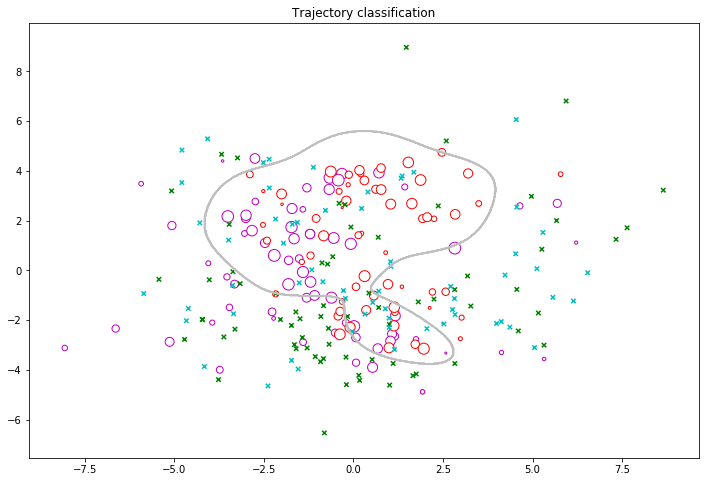

In [148]:
def plotClassifier(traj_svm, traj_pca, labels, ages, colors0=None, colors1=None):
    
    def make_meshgrid(x, y, h=.02):
        """Create a mesh of points to plot in

        Parameters
        ----------
        x: data to base x-axis meshgrid on
        y: data to base y-axis meshgrid on
        h: stepsize for meshgrid, optional

        Returns
        -------
        xx, yy : ndarray
        """
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        return xx, yy


    def plot_contours(ax, clf, xx, yy, **params):
        """Plot the decision boundaries for a classifier.

        Parameters
        ----------
        ax: matplotlib axes object
        clf: a classifier
        xx: meshgrid ndarray
        yy: meshgrid ndarray
        params: dictionary of params to pass to contourf, optional
        """
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contour(xx, yy, Z, **params)
        return out

    X0 = traj_pca[:,0]
    X1 = traj_pca[:,1]
    y = labels
    xx, yy = make_meshgrid(X0, X1)
    fig, sub = plt.subplots(1, 1, figsize=(12, 8))
    ax = sub
    
    clf = traj_svm

    plot_contours(ax, clf, xx, yy, colors='#BFBFBF')

    print('X0[y==1]', X0[y==1].shape)
    print('X0[y==0]', X0[y==0].shape)
    ax.scatter(X0[y==1], X1[y==1], marker='o', c='w', edgecolors=colors1 if colors1 else 'r', s=ages)
    ax.scatter(X0[y==0], X1[y==0], marker='x', s=20, c=colors0 if colors0 else 'b')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    ax.set_title('Trajectory classification')

    plt.show()

    
#plotClassifier(traj_svm1, traj_pca1, labels1, ages=2*np.arange(traj_pca1.shape[0]))
#plotClassifier(traj_svm2, traj_pca2, labels2, ages=2*np.arange(traj_pca2.shape[0]))


ages=2*np.concatenate([np.arange(traj_pca1[labels1==1].shape[0]), np.arange(traj_pca2[labels2==1].shape[0])])
colors1=['m']*traj_pca1[labels1==1].shape[0] + ['r']* traj_pca2[labels2==1].shape[0] 
colors0=['g']*traj_pca1[labels1==0].shape[0] + ['c']* traj_pca2[labels2==0].shape[0] 
print(len(colors))
plotClassifier(traj_svm_both, traj_pca_both, labels_both, ages=ages, colors0=colors0, colors1=colors1)